*The prerequisits recommendations for this notebook are: [Single Lens](SingleLens.ipynb) and [Galactic Model](GalacticModel.ipynb).*

In [ ]:
# package imports (SHIFT + ENTER to run)
import os
import sys
import math
import numpy as np
import fcntl
import multiprocessing as mp
import time
import matplotlib.pyplot as plt

# GULLS (in development)
Gulls is a mission simulation code written by Mathew Peeny for the purpose of determining exoplanet occurance rates from the Roman mission. Its function and results are throuroughly described in the following papers: [Penny at al. (2019)](https://iopscience.iop.org/article/10.3847/1538-4365/aafb69/pdf) and [Penny et al. (2013)](https://arxiv.org/pdf/1206.5296). For the purposed of this notebook, we will be concentrating mostly on the details regarding use of this code. Gulls is freely available on [GitHub](https://github.com/gulls-microlensing/gulls). The dev version is [here](https://github.com/gulls-microlensing/gulls/tree/dev). I believe to pull this branch you'll need to do the following git commands:
```bash
git fetch origin dev
git merge dev
```

There are up to date [observatory files](https://lsu.box.com/s/ypk9lnvfjt9vn7zs68bdql9fwf0mn0ex) here for now and a good fraction of the  [synthpop catalogs](https://lsu.box.com/v/gulls-surot2d-H2023) can be found here (these are very large)





## Modularity
Gulls is designed to be highly modular. The simulation code runs by loading text files of planet, lens, and source samples. It applies filter, candence, telescope optics and camera metrics, and reduction approximations using information provided in a parameter file. The outputs are text files for event parameters and weights, lightcurves, and Ficher matrix approximations of SL lightcurve fit posteriors. We can easily replace the source and lens sample files for ones created with a different galactic model, extinction map, or different pointings. We can swap our planetary catalouges to one weighted by a different planetary mass function. We can swap of filters, observation location, cadence or camera array by providing a different option in the parameter file. The same skeleton gulls codes can be used to simulated events and determine occurance rates, with a variety of different mission designs.

+ [] add starlists under galactic model
+ [] add field image next to geometry
+ [] replace first LC image with a set of "science" images
+ [] replace the html with a static image


<div style="display: flex; justify-content: center; align-items: center;">
    <div style="margin-right: 0px;">
        <div style="font-size: 40px; line-height: 0.5; text-align: center; margin-top: 20px; margin-bottom: 10px; margin-left: -120px;">
            planet model
        </div>
        <div style="font-size: 20px; line-height: 0.5; text-align: center; margin-top: 20px; margin-bottom: 40px; margin-left: -120px;">
            (e.g. the Casan et al., 2010 mass function)
        </div>
        <img src="./Assets/planetMF.jpg" alt="planetary mass function" height="325">
        <div style="font-size: 50px; line-height: 0.5; margin-top: 20px; margin-bottom: 30px; text-align: center; margin-left: -120px;">
            &#x2193;
        </div>
    </div>
    <div style="margin-left: -220px;">
        <div style="font-size: 40px; line-height: 0.5; text-align: center; margin-top: 20px; margin-bottom: 10px;">
            galactic model
        </div>
        <div style="font-size: 20px; line-height: 0.5; text-align: center; margin-top: 20px; margin-bottom: 50px;">
            (e.g. synthpop; velocity, density, mass, magnitude)
        </div>
        <img src="./Assets/Milky_Way.jpg" alt="milky way model" height="300">
        <div style="display: flex; justify-content: space-between; margin-top: 20px;">
            <div style="font-size: 50px; line-height: 0.5; margin-bottom: 10px; margin-left: 80px;">
                &#x2193;
            </div>
            <div style="font-size: 50px; line-height: 0.5; margin-bottom: 10px; margin-right: -100px;">
                &#x2193;
            </div>
        </div>
    </div>
</div>

<div style="display: flex; justify-content: center; align-items: center;">
    <div style="text-align: center; margin-right: 0px;">
        <div style="font-size: 40px; line-height: 0.5; margin-top: 20px; margin-bottom: 45px;">
            companion objects
        </div>
        <img src="./Assets/planetlist.png" alt="planet list" height="200"> 
        <div style="font-size: 50px; line-height: 0.5; margin-top: 20px; margin-bottom: 10px;">
            &#x2193;
        </div>
    </div>
    <div style="text-align: center; margin-left: -40px;">
        <div style="font-size: 40px; line-height: 0.5; margin-top: 20px; margin-bottom: 10px;">
            lens objects
        </div>
        <div style="font-size: 20px; line-height: 0.5; margin-top: 20px; margin-bottom: 10px;">
            (no magnitude limit)
        </div>
        <img src="./Assets/lenslist.png" alt="lens list" height="200">
        <div style="font-size: 50px; line-height: 0.5; margin-top: 20px; margin-bottom: 10px;">
            &#x2193;
        </div>
    </div>
    <div style="text-align: center; margin-left: -20px;">
        <div style="font-size: 40px; line-height: 0.5; margin-top: 20px; margin-bottom: 10px;">
            source stars
        </div>
        <div style="font-size: 20px; line-height: 0.5; margin-top: 20px; margin-bottom: 10px;">
            (e.g. H<25 limited)
        </div>
        <img src="./Assets/starlist.png" alt="source list" height="200">
        <div style="font-size: 50px; line-height: 0.5; margin-top: 20px; margin-bottom: 10px;">
            &#x2193;
        </div>
    </div>
</div>

<div style="display: flex; justify-content: center; align-items: center;">
    <div style="margin-right: 0px;">
        <div style="font-size: 40px; line-height: 0.5; text-align: center; margin-top: 20px; margin-bottom: 10px; margin-left: -120px;">
            planet injection
        </div>
        <div style="font-size: 20px; line-height: 0.5; text-align: center; margin-top: 20px; margin-bottom: 2px; margin-left: -120px;">
            (<i>s, q, u<sub>0</sub></i>)
        </div>
        <img src="./Assets/planet.png" alt="another figure" height="325"> 
    </div>
    <div style="margin-left: -200px;">
        <div style="font-size: 40px; line-height: 0.5; text-align: center; margin-top: 20px; margin-bottom: 10px;">
            event geometry
        </div>
        <div style="font-size: 20px; line-height: 0.5; text-align: center; margin-top: 20px; margin-bottom: 10px;">
            (D<sub>S</sub>>D<sub>L</sub>)
        </div>
        <img src="./Assets/event_geometry.png" alt="event geometry" height="300">
    </div>
</div>

<div style="text-align: center;">
    <!-- Unicode down arrow with increased font size and margin -->
    <div style="font-size: 100px; line-height: 0.5; margin-bottom: 50px; margin-top: 20px;">
        &#x2193;
    </div>
    <div>
        <div style="font-size: 40px; line-height: 0.5; margin-top: 20px; margin-bottom: 40px;">
            generate science images
        </div>
        <img src="./Assets/apjsaafb69f11_hr.jpg" alt="penny2019 figure" width="500">
    </div>
    <div style="font-size: 100px; line-height: 0.5; margin-bottom: 50px; margin-top: 20px;">
        &#x2193;
    </div>
    <div>
        <div style="font-size: 40px; line-height: 0.5; margin-top: 20px; margin-bottom: 40px;">
            extract lightcurves
        </div>
        <img src="./Assets/apjsaafb69f11_hr.jpg" alt="penny2019 figure" width="500">
    </div>
    <div>
        <div style="font-size: 40px; line-height: 0.5; margin-top: 20px; margin-bottom: 40px;">
            fit a single lens lightcurve
        </div>
        <div style="font-size: 20px; line-height: 0.5; text-align: center; margin-top: 20px; margin-bottom: 10px;">
            (&#916;&#967;<sup>2</sup> = &#967;<sup>2</sup><sub>actual</sub> - &#967;<sup>2</sup><sub>single</sub>)
        </div>
    </div>
    <div style="display: flex; justify-content: center; align-items: center; margin-top: 20px;">
        <!-- Green circle with tick and text -->
        <div style="text-align: center; margin-right: 20px;">
            <div style="font-size: 24px; margin-bottom: 10px;">&#916;&#967;<sup>2</sup> &gt; 160</div>
            <svg width="100" height="100" viewBox="0 0 50 50">
                <circle cx="25" cy="25" r="25" fill="green" />
                <text x="25" y="25" dy="0.35em" font-size="30" text-anchor="middle" fill="white">&#x2714;</text>
            </svg>
        </div>
        <!-- Red circle with cross and text -->
        <div style="text-align: center;">
            <div style="font-size: 24px; margin-bottom: 10px;">&#916;&#967;<sup>2</sup> &lt; 160</div>
            <svg width="100" height="100" viewBox="0 0 50 50">
                <circle cx="25" cy="25" r="25" fill="red" />
                <text x="25" y="25" dy="0.35em" font-size="30" text-anchor="middle" fill="white">&#x2716;</text>
            </svg>
        </div>
    </div>
</div>

<div style="text-align: center; margin-top: 50px; margin-bottom: 50px;">
    <img  src="./Assets/occurance_rates.png" alt="penny2019 figure" width="500">
</div>


## Language
Gulls is primarily built in pearl and c++. The scripts to create the required input catalogues are pearl. Pearl is a fast maguage and this speed allows us to create large catologues very fast. The bones of the gulls simulations procedures are build in c++. The simulation and fitting of each event is independent of the other events in the catalogue. This makes these simulations embarassingly parallelisable. c and c++ are typical laguage choices for parallelisable jobs. c++ reequires an objects size in memory to be specified at initilisation; there is no appending a list. This is usufull in parallelised code because it avoids memory overlaps or time spent reorganiseing an objects location in memory as it grows. This priciple is the same as why numpy arrays are so much faster than python for loops. The array is size defined at intilisation and operations on these array run on c backends. It is also how cython achieves for loop speed up; the cython additions require you to inilisae your python objects with a defined type and size, similar to c and c++. The analysis process for a simulation run is usually a baspoke process. There are some python scripts to aid in the analysis process, where ease of use is a more pressing concern than than speed. 

## Monte Carlo inference
Gulls determines occurance rates through monte carlo inference. Its draws from samples of lens, and source objects create using a galactic model. These samples, weighted by their effective area, become the galactic model prior in the inference. Each lens source combination has an optical depth and event rate which are used to weight the events samples acording to there probability of lensing. For example, if the source is closer to the observer than the lens there is 0 probaility of a lensing event. These weights are defined as follows:

equation

The planet samples can be drawn from any distribution, but some distributions make for more efficient inference than others. If, for example, we draw from uniform planet distributions (the samples in our planet catalgue would have mass and semi-majoraxis histograms that are flat). However, these mass and semi-major axis will be tranformed into s and q in the planet injection step and s and q are not uniformly efficient at creating detectable planet singnals in light curves. Microlensing is most efficient at detecting s and q of 1. So a uniform planet prior will result in excessive sampling in the s=1, q=1 parameter space, and a relative undersampling in high s and low q (i.e. low mass, high semimajor axis); the parameter space of greatest interest for eoplanet studies. The benefit of monte carlo intergration is that we can keep collecting samples untill the whole parameter space is well sampled, but it would be more efficient to draw more often from those parameters than are less likely to show detection, so that the posterior is similarly well sampled in low probabily regions. In order to maintain our probability in the inference process, we weight the planet samples so as to transform the distribution from which we draw samples into the distribution we expect the planets to have. In our uniform examples, we might weight each mass draw according to its relative probabilty in a planetary mass function, such as the Cassan mass function. An event, with a planetary, lens and source sample, is acepted into the posterior sample if the planet is "detected" (the criteria from this is discussed in the following section). Each posterior sample then has weights to transform the sample into the representive posterior. There is a planetary weight, which transform the planetary prior to match an expected distribution, and an event weight, which transforms the lens and source priors to incorporate the probability of a lensing event occuring. 

## Lightcurve analysis

## Installation

## Post processing

## Toybox example

The length of a planet file (nl) dictates the length of a gulls subrun. The subruns (nf) are independent and can be increased incrementally to reduce the uncertainty in the infered yeild estimates. Here we will step through the GULLS pre-processing, simulation, and post-processing steps in a short example run. 

In [3]:
# Append the Modules directory to sys.path
sys.path.append("../Modules")
from Simulations import Planet

In [4]:
# Creating planet samples
#start_time = time.time()
planet = Planet(live_run=True, nl=5)  # nf = no. of cores / 2
planet.draw_planet_sample()
print('state:', planet.state[:,:,:])    # shape: [nf (no of files/processes), nl (number of samples per file/process, 
                                        #        4 (m, a, i, phi)]
#end_time = time.time()
#print(f"Execution time: {end_time - start_time:.2f} seconds")

Initializing Planet class...


/Users/malpas.1/Code/eLearning/TheMicrolensersGuideToTheGalaxy/Notebooks/../Modules/Simulations.py:140: RuntimeWarning: invalid value encountered in arccos
  np.arccos(2.0 * rnd),
/Users/malpas.1/Code/eLearning/TheMicrolensersGuideToTheGalaxy/Notebooks/../Modules/Simulations.py:141: RuntimeWarning: invalid value encountered in arccos
  -np.arccos(2.0 - 2.0 * rnd)
/Users/malpas.1/Code/eLearning/TheMicrolensersGuideToTheGalaxy/Notebooks/../Modules/Simulations.py:140: RuntimeWarning: invalid value encountered in arccos
  np.arccos(2.0 * rnd),
/Users/malpas.1/Code/eLearning/TheMicrolensersGuideToTheGalaxy/Notebooks/../Modules/Simulations.py:141: RuntimeWarning: invalid value encountered in arccos
  -np.arccos(2.0 - 2.0 * rnd)


state: [[[ 1.39759281e-05  2.26710635e+01 -8.63268135e+01  3.59389854e+02]
  [ 9.31270178e-07  9.75740899e-01 -3.82945103e+01  3.48470804e+02]
  [ 1.63021023e-04  4.96107124e-01  2.75156802e+01  4.30243480e+01]
  [ 6.56352411e-06  3.06163904e+00 -7.21772007e+01  1.28668968e+02]
  [ 1.18804135e-05  1.51757544e+01 -6.62446290e+01  1.77722985e+02]]

 [[ 1.13898397e-05  6.94099748e-01  6.56849784e+01  1.09678385e+02]
  [ 8.44368763e-05  3.53259558e-01  7.29098125e+01  1.63184726e+02]
  [ 1.68659533e-05  1.46558807e+01 -2.32945952e+01  2.26956918e+01]
  [ 6.11045697e-05  3.00854196e-01  4.55255798e+01  1.36799800e+02]
  [ 4.20136726e-07  3.99948508e-01  5.49481947e+01  3.41294533e+01]]

 [[ 5.90685634e-06  4.27755861e-01  6.97682146e+01  1.46829151e+02]
  [ 2.37663331e-05  3.14499025e+00  1.53191179e+01  1.58634243e+02]
  [ 1.21962727e-05  3.41288772e+00  7.20332650e+01  1.14257104e+02]
  [ 7.04414842e-07  2.19115057e+00 -1.72539813e+01  7.52349040e+01]
  [ 2.76102874e-06  1.82100218e+00 -8

/Users/malpas.1/Code/eLearning/TheMicrolensersGuideToTheGalaxy/Notebooks/../Modules/Simulations.py:140: RuntimeWarning: invalid value encountered in arccos
  np.arccos(2.0 * rnd),
/Users/malpas.1/Code/eLearning/TheMicrolensersGuideToTheGalaxy/Notebooks/../Modules/Simulations.py:141: RuntimeWarning: invalid value encountered in arccos
  -np.arccos(2.0 - 2.0 * rnd)
/Users/malpas.1/Code/eLearning/TheMicrolensersGuideToTheGalaxy/Notebooks/../Modules/Simulations.py:140: RuntimeWarning: invalid value encountered in arccos
  np.arccos(2.0 * rnd),
/Users/malpas.1/Code/eLearning/TheMicrolensersGuideToTheGalaxy/Notebooks/../Modules/Simulations.py:141: RuntimeWarning: invalid value encountered in arccos
  -np.arccos(2.0 - 2.0 * rnd)


<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 1</h2>
    <p>Take a look at the <i>Planet</i> class in the <i>Simulations</i> module. What distribution are the mass and semimajor axis being drawn from?</p>
    <br>
</div>

In [5]:
# load and print a text file saved in exercises with the answer: log-uniform
with open('./Exercises/BinarySourceE1.txt', 'r') as answer:
    print(answer.read())

log-uniform


<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 2</h2>
    <p>What do the planet parameter distributions look like?</p>
    <br>
    <p>Set up a <i>Planet</i> object with <i>nl=200</i> and <i>live_run=True</i>.</p>
    <p>The Python cell below shows you how to reshape your planet sample into something continuous, instead of chunked.</p>
    <br>
</div>

In [6]:
sample = planet.state.reshape(planet.state.shape[0]*planet.state.shape[1], planet.state.shape[2])
print('sample:', sample)

sample: [[ 1.39759281e-05  2.26710635e+01 -8.63268135e+01  3.59389854e+02]
 [ 9.31270178e-07  9.75740899e-01 -3.82945103e+01  3.48470804e+02]
 [ 1.63021023e-04  4.96107124e-01  2.75156802e+01  4.30243480e+01]
 [ 6.56352411e-06  3.06163904e+00 -7.21772007e+01  1.28668968e+02]
 [ 1.18804135e-05  1.51757544e+01 -6.62446290e+01  1.77722985e+02]
 [ 1.13898397e-05  6.94099748e-01  6.56849784e+01  1.09678385e+02]
 [ 8.44368763e-05  3.53259558e-01  7.29098125e+01  1.63184726e+02]
 [ 1.68659533e-05  1.46558807e+01 -2.32945952e+01  2.26956918e+01]
 [ 6.11045697e-05  3.00854196e-01  4.55255798e+01  1.36799800e+02]
 [ 4.20136726e-07  3.99948508e-01  5.49481947e+01  3.41294533e+01]
 [ 5.90685634e-06  4.27755861e-01  6.97682146e+01  1.46829151e+02]
 [ 2.37663331e-05  3.14499025e+00  1.53191179e+01  1.58634243e+02]
 [ 1.21962727e-05  3.41288772e+00  7.20332650e+01  1.14257104e+02]
 [ 7.04414842e-07  2.19115057e+00 -1.72539813e+01  7.52349040e+01]
 [ 2.76102874e-06  1.82100218e+00 -8.99183412e+01  2.9

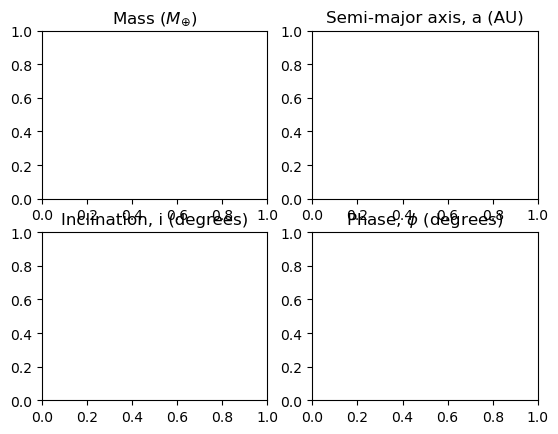

In [7]:
# Close figure 1 if it exists
plt.close(1)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, num=1)

# Access each subplot using the 2D array of axes
axs[0, 0].set_title(r'Mass ($M_{\oplus}$)')
axs[0, 1].set_title(r'Semi-major axis, a (AU)')
axs[1, 0].set_title('Inclination, i (degrees)')
axs[1, 1].set_title(r'Phase, $\phi$ (degrees)')

# Plot the histograms
# your code here !!

# Show the plot
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json

class Field:
    def __init__(self, x_size, y_size, pointing, model_base_name=None, filters=['default_filter'], 
                 psf_model='default_psf', model_name="besancon_Robin2003", 
                 extinction_map={"extinction_map_kwargs": {"name": "Marshall"}, 
                                 "extinction_law_kwargs": {"name": "ODonnellCardelli"}
                                 }, 
                solid_angle=5.0e-3, name_for_output=None):
        self.x_size = x_size
        self.y_size = y_size
        self.l, self.b = pointing
        self.filters = filters
        self.psf_model = psf_model
        self.galactic_model = model_name
        self.extinction_map = extinction_map
        self.solid_angle = solid_angle
        if model_base_name is None:
            self.model_base_name = f"{self.l}-{self.b}-{self.solid_angle}-{self.galactic_model}"
        date = datetime.now().strftime("%Y%m%d")  # Format the date as YYYYMMDD
        if name_for_output is None:
            self.name_for_output = self.key+date
        self.name_for_output = name_for_output

    def create_json_file(self):
        data = {
            "model_base_name": self.model_base_name,
            "name_for_output": self.name_for_output,
            "l_set": [self.l],
            "b_set": [self.b],
            "solid_angle": self.solid_angle,
            "model_name": self.galactic_model,
            "evolution_class": {
                "name": "MIST",
                "interpolator": "CharonInterpolator"
            },
            "extinction_map_kwargs": self.extinction_map["extinction_map_kwargs"],
            "extinction_law_kwargs": self.extinction_map["extinction_law_kwargs"],
            "delta_t_minutes": [192, 15],
            "microlensing_event_parameters": {
                "mag_bin_edges": [20, 21, 22, 23, 24, 25, 26],
                "events_u0_per_mag_bin": [[200, 0.1], [200, 0.01], [200, 0.001]],
                "t_E_mins": 200,
                "t0_mins": 2160
            }
        }

        with open('synthpop_config.json', 'w') as json_file:
            json.dump(data, json_file, indent=4)

    def draw_lens_sample(self):
        # Placeholder for draw_lens_sample method
        pass

    def draw_source_samples(self):
        # Placeholder for draw_source_samples method 
        pass

    def generate_field(self):
        # Placeholder for generate_field method
        pass



class Event:
    def __init__(self, field, planet):
        self.field = field
        self.planet = planet

    def generate_microlensing_events(self, n):
        self.field.create_json_file(n)
        self.field.draw_lens_sample(n)
        self.field.draw_source_samples(n)
        self.field.generate_field(n)  # n?
        self.planet.draw_planet_sample(n)

    def prior(self):
        # Placeholder for prior method
        self.generate_microlensing_events(self.nwalker)


    def generate_science_images(self):
        # Placeholder for generate_science_images method
        pass

    def extract_lightcurve(self):
        # Placeholder for extract_lightcurve method
        pass

    def binary_magnification(self):
        # Placeholder for binary_magnification method
        pass


## Lens Orbital Motion

In [9]:
from typing import Union
import numpy as np

def calc_period(m: Union(float, np.ndarray), 
                M: Union(float, np.ndarray), 
                a:Union(float, np.ndarray)) -> Union(float, np.ndarray):
    '''
    Parameters
    ----------
    m : float or np.ndarray
        The mass of the planet in solar masses.
    M : float or np.ndarray
        The mass of the star in solar masses.
    a : float or np.ndarray
        The semi-major axis of the planet in au.

    Returns
    -------
    float or np.ndarray
        The period of the planet.

    Notes
    -----
    $$T^2=4\pi2G(M+m)a^3.$$
    '''

    T  = np.sqrt((M+m)*a**3)

    return T

def calc_s_with_LOM(T: Union(float, np.ndarray), 
             a: Union(float, np.ndarray), 
             e: Union(float, np.ndarray), 
             i: Union(float, np.ndarray), 
             phi: Union(float, np.ndarray), 
             t: Union(float, np.ndarray)) -> np.ndarray:
    '''
    Calculate the x, y, z coordinates of the planet at time t.

    Parameters
    ----------
    T : float or np.ndarray
        The period of the planet in seconds.
    a : float or np.ndarray
        The semi-major axis of the planet in au.
    e : float or np.ndarray
        The eccentricity of the planet.
    i : float or np.ndarray
        The inclination of the planet in radians.
    phi : float or np.ndarray
        The phase of the planet in radians.
    t : float or np.ndarray
        data epochs in days since the start of the simulation (t=t0, to recover the binary model parameter, s)

    Returns
    -------
    np.ndarray
        The projected seperation (s) of the planet at epochs t, in units of au.
    '''

    # Calculate the mean anomaly
    M = 2*np.pi*t/T

    # Calculate the eccentric anomaly
    E = M + e*np.sin(M)

    # Calculate the true anomaly
    v = 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2))

    # Calculate the projected seperation
    s = a*(1-e**2)/(1+e*np.cos(v))

    return s


TypeError: Cannot instantiate typing.Union